<a href="https://colab.research.google.com/github/hafeez42/marketing_data_science/blob/master/A_B_test_of_Mobile_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# import json file into colab
from google.colab import files
files.upload()

# setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# verifying json file content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s A/B 

ref                                                title                                           size  lastUpdated          downloadCount  
-------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
yufengsui/mobile-games-ab-testing                  Mobile Games: A/B Testing                      490KB  2019-07-22 08:37:03           1459  
ttahara/birdsong-resampled-train-audio-00          birdsong resampled train audio 00 (a ~ b)       12GB  2020-07-04 13:16:57           1995  
zhangluyuan/ab-testing                             A/B testing                                      4MB  2018-06-25 15:47:34           3158  
ilkeryildiz/example-dataset-for-ab-test            Example Dataset for A/B Test                     2KB  2021-10-03 19:45:11            126  
futurecorporation/epitope-prediction               COVID-19/SARS B-cell Epitope Prediction          1MB  2020-07-24 02:53:28           2560  
chebot

In [ ]:
# download the dataset from kaggle
!kaggle datasets download -d yufengsui/mobile-games-ab-testing

# unzip files
!unzip \*.zip

  0% 0.00/490k [00:00<?, ?B/s]
100% 490k/490k [00:00<00:00, 16.2MB/s]
Archive:  mobile-games-ab-testing.zip
  inflating: cookie_cats.csv         


In [ ]:
data = pd.read_csv('cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Exploratory Analysis
In the given data, the game is installed by 90,189 players.
The variables are:

 - userid - a unique number that identifies each player.
 - version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
 - sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
 - retention_1 - did the player come back and play 1 day after installing?
 - retention_7 - did the player come back and play 7 days after installing?

First, let's check the class distribution

### Class Distribution

In [ ]:
print(data.version.value_counts())

gate_40    45489
gate_30    44700
Name: version, dtype: int64


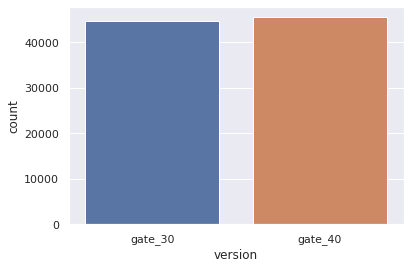

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(x = "version", data=data)
plt.show()

It looks like there is roughly the same number of players in each group.
The focus of this analysis is on how the gate placement affects player retention.
Let's plot the distribution of the number of game rounds players played during their first week playing the game.

### The Distribution of Game Rounds

Text(0, 0.5, 'userid')

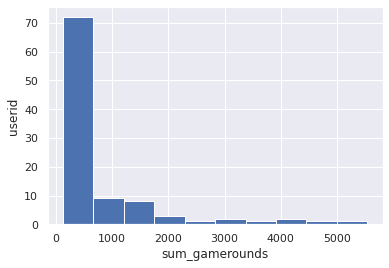

In [ ]:
# Counting the number of players for each number of gamerounds 
plot_df = data.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x='sum_gamerounds', y='userid', kind= 'hist')
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("userid")

From the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some really start enjoying it!


# Overall 1-day retention


We want players to enjoy the game and become addicted to it. The percentage of players who come back and play the game one day after installing it is a typical indicator in the video gaming industry evaluating how exciting and engaging it is. It is easier to keep gamers and grow a huge player base with a high 1-day retention rate.

In [ ]:
np.multiply(np.mean(data['retention_1']), 100).round(2)

44.52


As a result, somewhat less than half of the gamers return one day after downloading the game. Now that we have a benchmark let's see how 1-day retention compares between the two AB groups.

### 1-Day Retention A/B Group

In [ ]:
data.groupby('version')['retention_1'].agg('mean')

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It seems, when the gate was moved to level 40 (44.2%), there appeared to be a slight drop in 1-day retention compared to the control group when it was at level 30. (44.8%). It's a minor difference, but even minor improvements in retention can have a significant influence. But, while the data difference is certain, how certain can we be that a level 40 gate will be worse in the future?

We can determine the certainty of these retention figures in a handful of ways. We'll use bootstrapping in this case: We'll re-sample our dataset (with replacement) several times and determine 1-day retention for each sample. The fluctuation in 1-day retention will indicate how unreliable the retention figures are.

### Bootstraping

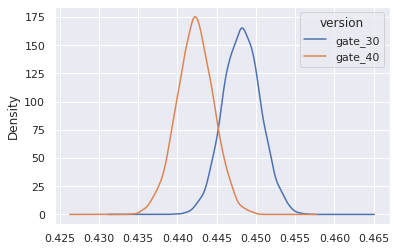

In [ ]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(5000):
    boot_mean = data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind = 'kde')

The two distributions above represent the bootstrap uncertainty for the underlying 1-day retention for the two AB groups. By simply looking at this graph, we can tell that there appears to be some indication of a difference, albeit minor. So, let's take a closer look at the difference in 1-day retention.

Text(0.5, 0, '% difference in means')

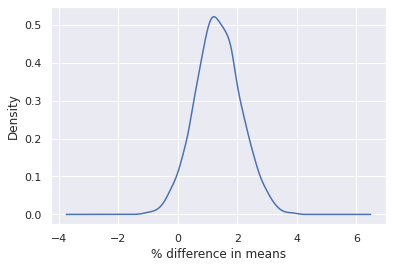

In [ ]:
# adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

We can see from this graph that the most likely percent difference is approximately 1% and that the majority of the distribution is above 0%, favoring a gate at level 30. But what are the chances that the difference is more than 0%? Let's do the math on it as well.

In [ ]:
# calculating the probability that 1-day retention is greater when the gate is at level 30
prob = np.mean(boot_1d['diff'] > 0.0)

# printing the probability
'{:.1%}'.format(prob)

'96.1%'

The bootstrap results indicated that if the gate is at level 30, there is a strong possibility of better 1-day retention. However, because most players have only been playing for one day, they probably haven't yet achieved level 30. That is, even if the gate appears at level 30, many players will not have been affected.

However, more players should have achieved level 40 after a week of play; thus, it seems reasonable to look at 7-day retention. For example, what percentage of users who downloaded the game returned to play it again a week later?

To begin, compute 7-day retention for the two AB groups.

# 7 Day Retention A/B Group


In [ ]:
data.groupby('version')['retention_7'].agg('mean')

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

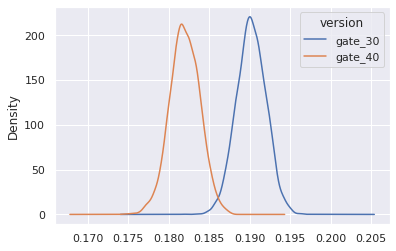

In [ ]:
boot_7d = []
for i in range(5000):
    boot_mean = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)
    
# Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot(kind = 'kde')

Text(0.5, 0, '% difference in means')

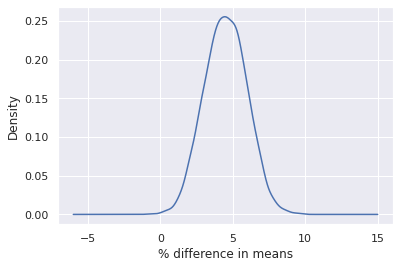

In [ ]:
# adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_40'] * 100

# ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

In [ ]:
# calculating the probability that 7-day retention is greater when the gate is at level 30
prob = np.mean(boot_7d['diff'] > 0.0)

# printing the probability
'{:.1%}'.format(prob)

'99.9%'

# Conclusion

The bootstrap result shows significant evidence that when the gate is at level 30, 7-day retention is higher than when it is at level 40. The conclusion is that we should not change the gate from level 30 to level 40 if we want to keep retention high – both 1-day and 7-day retention. Of course, we could look at additional measures, such as the number of game rounds played or the number of in-game purchases made by the two AB groups. However, one of the most crucial KPIs is retention. It doesn't matter how much money our players spend in-game if we don't keep them.

In [ ]:
move_to_gate40 = False